# Pretrained ResNet18 with hymenoptera_data

In [35]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [36]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.10.2  Device: cuda


In [37]:
BATCH_SIZE = 32
EPOCHS = 10

In [38]:
import os
os.getcwd()

'C:\\Users\\user'

In [39]:
''' 3. 개미와 벌을 분류하기 위해 개미 이미지 데이터와 벌 이미지 데이터 불러오기 (Train set, Test set 분리하기) '''
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(256), #왜 train과 다르게 설정했을까?
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

image_datasets = {x: datasets.ImageFolder("/hymenoptera_data", data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = BATCH_SIZE, num_workers = 0, shuffle = True) for x in ['train', 'val']}

In [40]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in dataloaders['train']:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

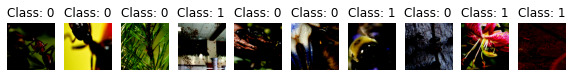

In [41]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


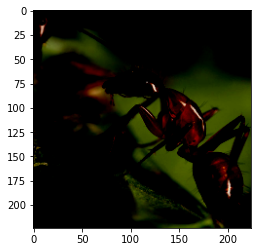

In [42]:
plt.imshow(np.transpose(X_train[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


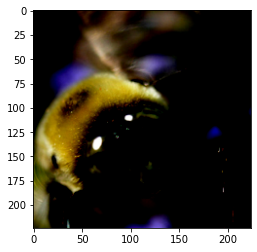

In [46]:
plt.imshow(np.transpose(X_train[6], (1, 2, 0)))

In [47]:
''' 6. 불러온 특정 모델에 대하여 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [48]:
''' 7. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [49]:
''' 8. PyTorch 내에서 제공하는 미리 학습되지 않은 ResNet18 모델 불러온 후 Output 크기 설정하기 '''
import torchvision.models as models
model = models.resnet18(pretrained = False).cuda()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

In [50]:
''' 9. Optimizer, Objective Function 설정하기 '''
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [52]:
train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size = BATCH_SIZE, num_workers = 0, shuffle = True)
test_loader = torch.utils.data.DataLoader(image_datasets['val'], batch_size = BATCH_SIZE, num_workers = 0, shuffle = False)

if torch.cuda.is_available():
    train_loader = torch.utils.data.DataLoader(dataset = image_datasets['train'],
                                               num_workers=12,
                                                batch_size = BATCH_SIZE,
                                                shuffle = True,
                                              persistent_workers=True)

In [53]:
''' 10. 미리 학습되지 않은 ResNet18 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 5)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.774113
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.714310
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.644256

[EPOCH: 1], 	Test Loss: 0.7343, 	Test Accuracy: 44.08 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.777126
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.716747
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.681715

[EPOCH: 2], 	Test Loss: 0.7473, 	Test Accuracy: 61.46 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.670170
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.643966
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.636377

[EPOCH: 3], 	Test Loss: 0.7049, 	Test Accuracy: 62.47 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.660462
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.622738
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.726635

[EPOCH: 4], 	Test Loss: 0.6873, 	Test Accuracy: 62.47 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.539409
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.579186
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.733712

In [54]:
''' 11. IMAGENET 데이터로 미리 학습이 된 ResNet18 모델을 불러온 후 개미, 벌 이미지 데이터에 맞게 Fine Tuning 해보기 '''
model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\user/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.763943
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.789715
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.655481

[EPOCH: 1], 	Test Loss: 0.6633, 	Test Accuracy: 68.01 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.526871
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.573358
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.584433

[EPOCH: 2], 	Test Loss: 0.5571, 	Test Accuracy: 71.28 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.480239
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.536364
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.498766

[EPOCH: 3], 	Test Loss: 0.4501, 	Test Accuracy: 82.87 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.406093
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.503602
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.441369

[EPOCH: 4], 	Test Loss: 0.3758, 	Test Accuracy: 87.91 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.412392
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.353822
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.287488

In [61]:
len(train_loader.dataset)

397

In [62]:
len(test_loader.dataset)

397